# Direct optimal control of a dubins car

We want to control an inverted pendulum and stabilize it in the upright position. The equations in Hamiltonian form describing an inverted pendulum with a torsional spring are as following:

$$\begin{equation}
    \begin{bmatrix} \dot{q}\\ \dot{p}\\ \end{bmatrix} = 
    \begin{bmatrix}
    0& 1/m \\
    -k& -\beta/m\\
    \end{bmatrix}
    \begin{bmatrix} q\\ p\\ \end{bmatrix} -
    \begin{bmatrix}
    0\\
    mgl \sin{q}\\
    \end{bmatrix}+
    \begin{bmatrix}
    0\\
    1\\
    \end{bmatrix} u
\end{equation}$$

In [1]:
import sys; sys.path.append(2*'../') # go n dirs back
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 

import torch
from torchdyn.numerics.odeint import odeint
from torchcontrol.systems.classic_control import DubinsVaryv
from torchcontrol.cost import IntegralCost
from torchcontrol.controllers import *

%load_ext autoreload
%autoreload 2

In [2]:
# Change device according to your configuration
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') # feel free to change :)
device = torch.device('cpu') # override

## Optimal control problem
In order to control the pendulum, we have to define a proper _integral cost function_ which will be our loss to be minimized during training. In a general form, it can be defined as:

$$\begin{equation}
        \min_{u_\theta} J = (x(t_f) - x^\star)^\top\mathbf{P} (x(t_f) - x^\star)) + \int_{t_0}^{t_f} \left[ (x(t) - x^\star)^\top \mathbf{Q} (x(t) - x^\star) + (u_\theta(t) - u^\star)^\top \mathbf{R} (u_\theta(t) - u^\star) \right] dt
\end{equation}$$

where $ x $ is the state and $u_\theta$ is the controller; $x^\star$ and $u^\star$ are the desired position and zero-cost controller; matrices $\mathbf{P},~\mathbf{Q}, ~ \mathbf{R}$ are weights for tweaking the performance.

In [24]:
# Declaring the cost function
x_star = torch.Tensor([0, 0, 0]).to(device)
u_star = 0.
cost = IntegralCost(x_star=x_star, u_star=u_star, P=1, Q=0, R=0)

## Initial conditions
Now we can see how the system behaves with no control input in time. Let's declare some initial variables:

In [25]:
from math import pi as π

# Time span
dt = 0.05 # step size
t0, tf = 0, 5 # initial and final time
steps = int((tf - t0)/dt) + 1
t_span = torch.linspace(t0, tf, steps).to(device)

# Initial distribution
x_0 = π # limit of the state distribution (in rads and rads/second)
# init_dist = torch.distributions.Uniform(torch.Tensor([-x_0, -x_0, -x_0]), torch.Tensor([x_0, x_0, x_0]))
init_dist = torch.distributions.Normal(torch.Tensor([-3, 0, 0]), torch.Tensor([1, 1, 1]))

## Box-constrained controller
We want to give a limited control input. We consider the box-constrained neural controller (parameters $\theta$ of $u_\theta$ belong to a feed-forward neural network):

In [26]:
# ?? BoxConstrainedController

In [27]:
# Controller
output_scaling = torch.Tensor([-1, 1]).to(device) # controller limits
u = BoxConstrainedController(3, 2, constrained=True, output_scaling=output_scaling).to(device)

# Initialize pendulum with given controller
dubins_car = DubinsVaryv(u, solver='euler')

## Optimization loop
Here we run the optimization: in particular, we use stochastic gradient descent with `Adam` to optimize the parameters

0.001 1.813187199499511e-05


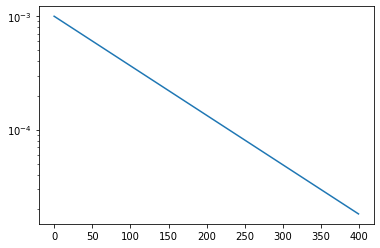

In [48]:
# dubins_car(init_dist.sample((16,)), t_span)
opt = torch.optim.Adam(u.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)
lrs = []

for i in range(400):
    opt.step()
    lrs.append(opt.param_groups[0]["lr"])

    scheduler.step()

plt.plot(lrs)
plt.yscale('log')
print(lrs[0], lrs[-1])

In [8]:
import math
def normal_pdf(x):
    mu = torch.tensor([[-1., 0.]])
    cov = torch.ones(2) * 0.5
    
    d = x.shape[-1]
    mu  = mu.view(1, d)
    cov = cov.view(1, d)

    denom = (2*math.pi)**(0.5*d) * torch.sqrt(torch.prod(cov))
    num   = torch.exp(-0.5 * torch.sum( (x - mu)**2 / cov , -1 , keepdims=True))

    return ((num/denom) * 100).mean()

In [9]:
xx = torch.ones(3,2,2) * -1
xx[..., -1] = 0
normal_pdf(xx)

tensor(31.8310)

In [46]:
def circle_obstacle(z, get_obs=False):

    rad = 0.5
    centers = torch.tensor([[-1., 0.]]).to(z.device)
    
    if get_obs:
        return (centers[0], rad)

    z_pos = z[..., :2]
    dist_to_circle0 = (z_pos - centers[0]).norm(2, -1)

    cost = (dist_to_circle0 < rad).float()
    return (cost * 9999).mean()

In [49]:
from tqdm import trange

# Hyperparameters
lr = 1e-3
epochs = 4000
bs = 1024
opt = torch.optim.Adam(u.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt)

# Training loop
losses=[]
with trange(0, epochs, desc="Epochs") as eps:
    for epoch in eps:    
        x0 = init_dist.sample((bs,)).to(device)
        trajectory = dubins_car(x0, t_span)  
        loss = cost(trajectory)
        loss += circle_obstacle(trajectory)
#         loss += normal_pdf(trajectory[..., :2])
        losses.append(loss.detach().cpu().item())
        opt.zero_grad(); loss.backward(); opt.step()
#         scheduler.step(loss)
        eps.set_postfix(loss=(loss.detach().cpu().item()), lr=opt.param_groups[0]["lr"])
        if epoch and epoch % 10 == 0:
            scheduler.step()

Epochs: 100%|██████████| 4000/4000 [1:46:50<00:00,  1.60s/it, loss=247, lr=1.81e-5]  


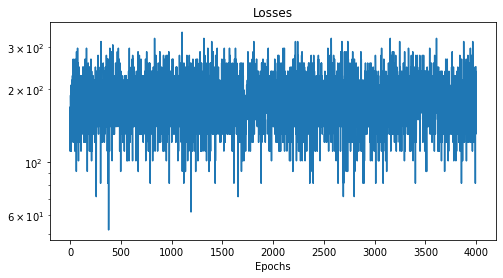

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.plot(losses)
ax.set_title('Losses')
ax.set_xlabel('Epochs')
ax.set_yscale('log')

## Plot results

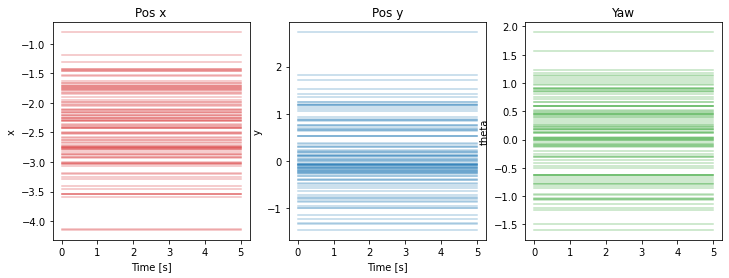

In [51]:
# Change the solver to 'dopri5' (adaptive step size, more accurate than Euler)
dubins_car.solver = 'dopri5'

# Forward propagate some trajectories 
x0 = init_dist.sample((100,)).to(device)*0.8

# Prolong time span
dt = 0.05 # step size
t0, tf = 0, 5 # initial and final time
steps = int((tf - t0)/dt) + 1
t_span = torch.linspace(t0, tf, steps).to(device)

traj = dubins_car(x0, t_span)

def plot_dubins_trajs():
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    for i in range(len(x0)):
        axs[0].plot(t_span.cpu(), traj[:,i,0].detach().cpu(), 'tab:red', alpha=.3)
        axs[1].plot(t_span.cpu(), traj[:,i,1].detach().cpu(), 'tab:blue', alpha=.3)
        axs[2].plot(t_span.cpu(), traj[:,i,2].detach().cpu(), 'tab:green', alpha=.3)
    axs[0].set_xlabel(r'Time [s]'); axs[1].set_xlabel(r'Time [s]')
    axs[0].set_ylabel(r'x'); axs[1].set_ylabel(r'y'); axs[2].set_ylabel(r'theta')
    axs[0].set_title(r'Pos x'); axs[1].set_title(r'Pos y'); axs[2].set_title(r'Yaw')
    
    
plot_dubins_trajs()

(-5.0362698074430226,
 0.30889476947486405,
 -2.1525764882564546,
 2.6318599402904512)

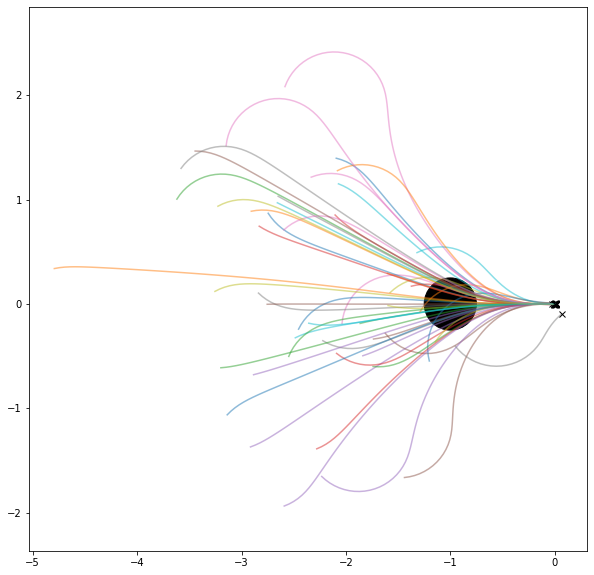

In [37]:
# for i in range(len(x0)):
fig, axs = plt.subplots(1, 1, figsize=(10,10))
# plt.rcParams["figure.figsize"] = (10,10)
for i in range(50):
    axs.plot(traj[:,i,0].detach().cpu(), traj[:,i,1].detach().cpu(), alpha=.5)
    axs.plot(traj[-1,i,0].detach().cpu(), traj[-1,i,1].detach().cpu(), 'kx')
    

obs_data = circle_obstacle(traj, get_obs=True)
obs_patch = mpatches.Circle(obs_data[0], obs_data[1] * 0.5, color='k')
axs.add_patch(obs_patch)

plt.axis('equal')

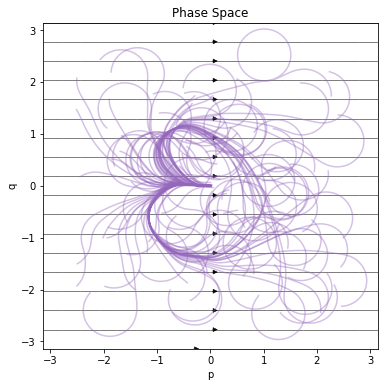

In [64]:
# Plot learned vector field and trajectories in phase space
n_grid = 50
graph_lim = π

def plot_phase_space():
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    x = torch.linspace(-graph_lim, graph_lim, n_grid).to(device)
    Q, P = torch.meshgrid(x, x) ; z = torch.cat([Q.reshape(-1, 1), P.reshape(-1, 1), 0*torch.ones_like(Q).reshape(-1, 1)], 1)
    f = dubins_car.dynamics(0, z).detach().cpu()
    Fq, Fp = f[:,0].reshape(n_grid, n_grid), f[:,1].reshape(n_grid, n_grid)
    val = dubins_car.u(0, z).detach().cpu()
    ax.streamplot(Q.T.detach().cpu().numpy(), P.T.detach().cpu().numpy(),
                    Fq.T.detach().cpu().numpy(), Fp.T.detach().cpu().numpy(), color='black', density=0.6, linewidth=0.5)

    ax.set_xlim([-graph_lim, graph_lim]) ; ax.set_ylim([-graph_lim, graph_lim])
    traj = dubins_car(x0, t_span).detach().cpu()
    for j in range(traj.shape[1]):
        ax.plot(traj[:,j,0], traj[:,j,1], color='tab:purple', alpha=.4)
    ax.set_title('Phase Space')
    ax.set_xlabel(r'p')
    ax.set_ylabel(r'q')
    
plot_phase_space()

Nice! The controller manages to stabilize the pendulum in our desired $x^\star$ 🎉